### Compare fits for pct_high, pct_low, ... etc

In [10]:
from sqlalchemy import create_engine
engine = create_engine('mysql+pymysql://localhost',
                       connect_args={'read_default_file': '~/.mytest.cnf'})
conn = engine.connect()

In [11]:
import pandas as pd
tck_qry = pd.read_sql_query('''select symbol, avg(volume*close) from USE_2021
    group by symbol order by avg(volume*close) desc limit 20''',
                            conn)
tdf = pd.DataFrame(tck_qry, columns=['symbol'])
tickers = tdf['symbol']

In [12]:
def query_symbol(sym, conn):
    qry = pd.read_sql_query(
        '''select tradedate, pct_open, pct_high, pct_low, pct_close,
         pct_hilo, pct_opclo from USEQ_HIST
        where symbol="''' + sym + '''"
        and volume>0
         order by tradedate''',
        conn,
        index_col='tradedate'
    )
    return sym, pd.DataFrame(qry, columns=["pct_open", "pct_high", "pct_low", "pct_close",
                                      "pct_hilo", "pct_opclo"])

In [13]:
import math
def ann_var(mean, var):
    return (math.sqrt((mean+var)*252))

In [14]:
from arch import arch_model
prices = ['pct_open', 'pct_high', 'pct_low', 'pct_close',
          'pct_hilo', 'pct_opclo']

In [15]:
rows = []
tickers=pd.Series(data=['MS']).append(tickers)
for tk in tickers:
    ticker, df = query_symbol(tk, conn)
    if(len(df.index)<100):
        print("len(df)", len(df.index), "for ticker", tk)
        continue
    for pr in prices:
        am = arch_model(df[pr], p=1, o=1, q=1, dist="StudentsT")
        res = am.fit(disp='off')
        forecasts = res.forecast(reindex=False)
        row = [tk, pr, res.loglikelihood, ann_var(forecasts.mean['h.1'].iloc[0], forecasts.variance['h.1'].iloc[0])
               ,res.nobs]
        rows.append(row)

    cmp = pd.DataFrame(rows, columns=['ticker', 'price', 'lhood', 'variance', 'nobs'])

compare = cmp.set_index(['ticker', 'price'])
compare.head(36)

lhood   variance  nobs
ticker price                                  
MS     pct_open  -2879.040230  29.471398  1456
       pct_high  -2719.369158  27.341716  1456
       pct_low   -2825.473096  27.077867  1456
       pct_close -2841.352857  28.204374  1456
       pct_hilo  -2081.393404  29.031317  1456
       pct_opclo -2527.537147  23.709376  1456
SPY    pct_open  -1628.338515  12.207781  1458
       pct_high  -1380.260050  12.190152  1458
       pct_low   -1667.363473  13.184374  1458
       pct_close -1662.894752  12.984633  1458
       pct_hilo  -1160.140670  14.307705  1458
       pct_opclo -1293.058202  10.050544  1458
TSLA   pct_open  -3711.469379  31.541645  1458
       pct_high  -3560.503137  37.645885  1458
       pct_low   -3607.856468  32.022921  1458
       pct_close -3679.393418  33.458420  1458
       pct_hilo  -2986.352228  37.514909  1458
       pct_opclo -3415.019628  25.663789  1458
QQQ    pct_open  -2090.279360  16.821194  1458
       pct_high  -1793.891405  14.333789  1458
       pct_low   -2068.704333  16.826393  1458
       pct_close -2077.302037  17.484804  1458
       pct_hilo  -1550.908038  17.077302  1458
       pct_opclo -1774.924491  12.741870  1458
AAPL   pct_open  -2685.542291  23.879204  1458
       pct_high  -2466.848326  22.534087  1458
       pct_low   -2603.969012  23.507031  1458
       pct_close -2677.500042  22.380554  1458
       pct_hilo  -1997.136886  22.716854  1458
       pct_opclo -2306.402751  16.791947  1458
AMZN   pct_open  -2768.034128  21.587891  1458
       pct_high  -2541.352599  23.736362  1458
       pct_low   -2697.000670  22.125193  1458
       pct_close -2717.622124  25.710699  1458
       pct_hilo  -2102.468333  28.579043  1458
       pct_opclo -2470.293573  21.489145  1458

<AxesSubplot:ylabel='Frequency'>

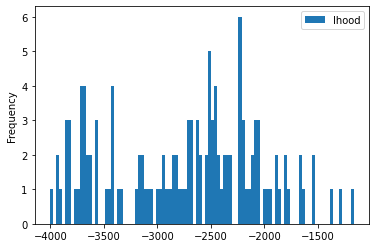

In [16]:
compare[['lhood']].plot(bins=100, kind='hist')

<AxesSubplot:ylabel='Frequency'>

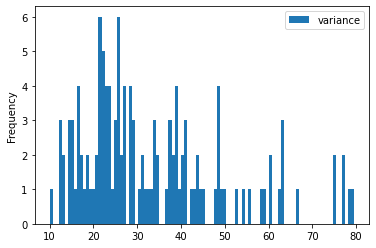

In [17]:
compare[['variance']].plot(bins=100, kind='hist')

In [18]:
conn.close()